# Functional Encryption - Classification and information leakage
 
We compute here the collateral accuracy on the disctintion task for a large class of network on a pretrained network which has a good resistance. We actually trained as explained in the previous parts, but on a remote server so we load it directly.

# 8. Collateral Learning assessed with Advantage


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

In [45]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 0 # <--- NO SABOTAGE
        self.new_adversary_epochs = 50 #50
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 10000

In [4]:
PRIVATE_OUTPUT_SIZE = 4
N_CHARS = 10
N_FONTS = 2

## 8.1 Loading $Q$ with resistance

In [5]:
class CollateralNet(nn.Module):
    def __init__(self, private_output_size):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, private_output_size, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(private_output_size, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(private_output_size, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)
        
        # FFN for families
        self.lin3 = nn.Linear(private_output_size, 64)
        self.lin4 = nn.Linear(64, 32)
        self.lin5 = nn.Linear(32, 16)
        self.lin6 = nn.Linear(16, 8)
        self.lin7 = nn.Linear(8, N_CHARS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

We load our pretrained model here

In [6]:
path = 'models/quadconvnet_0.5_0.002_1.7_4_6_par2.pt'
model = CollateralNet(private_output_size=PRIVATE_OUTPUT_SIZE)
results = {}

model.load_state_dict(torch.load(path))
model.eval()


CollateralNet(
  (proj1): Linear(in_features=784, out_features=40, bias=True)
  (diag1): Linear(in_features=40, out_features=4, bias=False)
  (lin1): Linear(in_features=4, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=10, bias=True)
  (jct): Linear(in_features=4, out_features=784, bias=True)
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=2, bias=True)
  (lin3): Linear(in_features=4, out_features=64, bias=True)
  (lin4): Linear(in_features=64, out_features=32, bias=True)
  (lin5): Linear(in_features=32, out_features=16, bias=True)
  (lin6): Linear(in_features=16, out_features=8, bias=True)
  (lin7): Linear(in_features=8, out_features=10, bias=True)
)

## 8.2 Testing distinguishability against multiples nets

We load the `Q` net that we have thoroughly built and it will be given to our new network structure

In [7]:
quadratic_model = model
quadratic_model.freeze('quad')

We now perform only the last phase with the new adversary, note that we change the data loader

In [8]:
fonts = ['cursive', 'Georgia']
letter = "6"

def evaluate_resistance(model, alpha=0):
    args = Parser()
    
    train_loader, test_loader = collateral.data.get_collateral_data_loaders(args, *fonts, letter)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    #optimizer = optim.Adam(model.parameters())
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        
        print(model.proj1.weight[30:35, 60])
        initial_phase = False
        perturbate = False
        recover = True
        
        new_adversary = True
        
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha,
            initial_phase, perturbate, recover, new_adversary
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

Here is the basic structure of a network like those seen previously. There is a quadratic part which inherits from the `Q` loaded, and a method `conv_font` is left empty so that we can provide arbitrary adversary by inheriting from this `BaseNet`.

In [9]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [23]:
resistance_reports = {}
resistance_reports_nice = {}

### 6.2.1 Fully connected models 

Here we inherit from BaseNet and we only have to specify `conv_font` and declare the layers used.

In [11]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = PRIVATE_OUTPUT_SIZE
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

In [14]:
import numpy as np

We now use a bunch of networks to have more results!


----- 0 / 45 [16]
Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 2.073008

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4730/10000 (47.30%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697932

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5048/10000 (50.48%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688401

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4904/10000 (49.04%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695165

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Fo


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5439/10000 (54.39%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687137

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5550/10000 (55.50%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675821

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5564/10000 (55.64%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703361

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5246/10000 (52.46%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675502

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5431/10000 (54.31%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694606

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5326/10000 (53.26%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.725125

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5603/10000 (56.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693413

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5270/10000 (52.70%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685257

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4965/10000 (49.65%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.714385

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5194/10000 (51.94%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686567

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5462/10000 (54.62%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696934

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5309/10000 (53.09%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698526

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5479/10000 (54.79%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679534

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5438/10000 (54.38%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671923

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5373/10000 (53.73%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.715581

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5642/10000 (56.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.651788

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5350/10000 (53.50%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694376

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5593/10000 (55.93%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.658305

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5359/10000 (53.59%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.663325

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5583/10000 (55.83%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691127

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5543/10000 (55.43%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696669

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5454/10000 (54.54%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684975

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5275/10000 (52.75%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.665282

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5455/10000 (54.55%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674310

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5442/10000 (54.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.716391

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5638/10000 (56.38%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.632299

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5526/10000 (55.26%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.707975

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5692/10000 (56.92%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685177

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5642/10000 (56.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.649048

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5357/10000 (53.57%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.665507

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5623/10000 (56.23%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697474

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5284/10000 (52.84%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.749545

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5442/10000 (54.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686280

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5416/10000 (54.16%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.647135

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5641/10000 (56.41%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682679

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5422/10000 (54.22%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.716599

Test set: Accuracy Char : 0/10000 (0.00%)



Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5688/10000 (56.88%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.613577

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5578/10000 (55.78%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695113

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5673/10000 (56.73%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679985

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5586/10000 (55.86%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683735

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5342/10000 (53.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.670602

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5403/10000 (54.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684266

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5277/10000 (52.77%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696104

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5522/10000 (55.22%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698810

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5152/10000 (51.52%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692039

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5560/10000 (55.60%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686180

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5556/10000 (55.56%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685591

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5315/10000 (53.15%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690723

Test set: Accuracy Char : 0/10000 (0.00%)


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5566/10000 (55.66%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.713867

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5717/10000 (57.17%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677265

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5676/10000 (56.76%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706419

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5634/10000 (56.34%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681878

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5425/10000 (54.25%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667771

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5514/10000 (55.14%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692594

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5217/10000 (52.17%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.707113

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5589/10000 (55.89%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700607

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5345/10000 (53.45%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688880

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5169/10000 (51.69%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672979

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5502/10000 (55.02%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677753

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5551/10000 (55.51%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689626

Test set: Accuracy Char : 0/10000 (0.00%)



Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5696/10000 (56.96%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.643008

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5530/10000 (55.30%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706684

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5677/10000 (56.77%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677457

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5626/10000 (56.26%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698776

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5555/10000 (55.55%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.654516

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5309/10000 (53.09%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.662512

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5537/10000 (55.37%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695280

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5196/10000 (51.96%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.713223

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5529/10000 (55.29%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694402

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5341/10000 (53.41%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699508

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5175/10000 (51.75%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.666703

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5488/10000 (54.88%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675155

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5222/10000 (52.22%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.715657

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5619/10000 (56.19%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.633261

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5483/10000 (54.83%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.704504

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5586/10000 (55.86%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682382

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5603/10000 (56.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699608

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5537/10000 (55.37%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674898

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5509/10000 (55.09%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.661456

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5582/10000 (55.82%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680119

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5140/10000 (51.40%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673469

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5209/10000 (52.09%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703946

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5279/10000 (52.79%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696629

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5412/10000 (54.12%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692851

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5630/10000 (56.30%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701310

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5472/10000 (54.72%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667118

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5417/10000 (54.17%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673252

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5501/10000 (55.01%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696972

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5453/10000 (54.53%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703161

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5544/10000 (55.44%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694626

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5443/10000 (54.43%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.704491

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5684/10000 (56.84%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680527

Test set: Accuracy Char : 0/10000 (0.00

Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.808258

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5120/10000 (51.20%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683601

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5510/10000 (55.10%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677744

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5195/10000 (51.95%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699194

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5119/10000 (51


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5724/10000 (57.24%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.704638

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5612/10000 (56.12%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.661402

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5623/10000 (56.23%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.707416

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5503/10000 (55.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669694

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5642/10000 (56.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671406

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5545/10000 (55.45%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698703

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5359/10000 (53.59%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.660109

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5447/10000 (54.47%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695100

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5661/10000 (56.61%)

----- 18 / 45 [32, 16, 32]
8:16:2                                   54.988
8:32:2                                   55.373000000000005
8:64:2                                   56.07000000000001
8:128:2                                  55.938
8:256:2                                  56.034000000000006
8:512:2                                  56.165
8:1024:2                                 56.419000000000004
8:32:16:2                                55.803
8:64:32:2                                56.428999999999995
8:128:64:2                               56.242999999999995
8:256:128:2                              56.30499999999999
8:512:256:2                              55.967
8:1024:512:2                             55.55899999999999
8:64:32:16:2                             56.911
8:128:64:32:2                            56.32000000000001
8:256:128:64:2                           56.338
8:512:256:1


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5576/10000 (55.76%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 31 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675715

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5693/10000 (56.93%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 32 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697051

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5605/10000 (56.05%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 33 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673408

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5670/10000 (56.70%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 34 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691978

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5313/10000 (53.13%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694506

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5433/10000 (54.33%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681373

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5469/10000 (54.69%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680988

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5321/10000 (53.21%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678150

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5575/10000 (55.75%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671818

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5597/10000 (55.97%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.663028

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5667/10000 (56.67%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.711658

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5662/10000 (56.62%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672944

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5473/10000 (54.73%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693789

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5343/10000 (53.43%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702264

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5591/10000 (55.91%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696830

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5437/10000 (54.37%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.664508

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5604/10000 (56.04%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691545

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5480/10000 (54.80%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685810

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5291/10000 (52.91%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.664811

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5638/10000 (56.38%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.675811

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5549/10000 (55.49%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.705407

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5643/10000 (56.43%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.638190

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5599/10000 (55.99%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.710990

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5684/10000 (56.84%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684524

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5583/10000 (55.83%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686399

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5499/10000 (54.99%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.705975

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5621/10000 (56.21%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680114

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5690/10000 (56.90%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677721

Test set: Accuracy Char : 0/10000 (0.00

Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.765430

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5154/10000 (51.54%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678208

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5320/10000 (53.20%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.670686

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5355/10000 (53.55%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696446

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5314/10000 (53


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5643/10000 (56.43%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701246

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5561/10000 (55.61%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.656720

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5626/10000 (56.26%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.709124

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5458/10000 (54.58%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667002

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5340/10000 (53.40%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686320

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5486/10000 (54.86%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698796

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5186/10000 (51.86%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702134

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5245/10000 (52.45%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685013

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5669/10000 (56.69%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667939

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5707/10000 (57.07%)

----- 25 / 45 [128, 64, 32, 16]
8:16:2                                   54.988
8:32:2                                   55.373000000000005
8:64:2                                   56.07000000000001
8:128:2                                  55.938
8:256:2                                  56.034000000000006
8:512:2                                  56.165
8:1024:2                                 56.419000000000004
8:32:16:2                                55.803
8:64:32:2                                56.428999999999995
8:128:64:2                               56.242999999999995
8:256:128:2                              56.30499999999999
8:512:256:2                 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5518/10000 (55.18%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674353

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5422/10000 (54.22%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.642972

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5647/10000 (56.47%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 31 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673339

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5718/10000 (57.18%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 32 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695390

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5497/10000 (54.97%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685845

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5179/10000 (51.79%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690313

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5552/10000 (55.52%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687390

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5583/10000 (55.83%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.684913

Test set: Accuracy Char : 0/10000 (0.00%)



Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5661/10000 (56.61%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.645997

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5622/10000 (56.22%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.710070

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5705/10000 (57.05%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690529

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5687/10000 (56.87%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700144

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5584/10000 (55.84%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698163

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5474/10000 (54.74%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.713981

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5693/10000 (56.93%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680705

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5668/10000 (56.68%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.668517

Test set: Accuracy Char : 0/10000 (0.00

Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690829

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5132/10000 (51.32%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686107

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5313/10000 (53.13%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681247

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5207/10000 (52.07%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696008

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5117/10000 (51


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5689/10000 (56.89%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698553

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5605/10000 (56.05%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.663346

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5627/10000 (56.27%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703950

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5515/10000 (55.15%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672526

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5298/10000 (52.98%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680792

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5416/10000 (54.16%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685536

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5431/10000 (54.31%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702238

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5355/10000 (53.55%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700786

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5667/10000 (56.67%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674339

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5644/10000 (56.44%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669362

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5705/10000 (57.05%)

----- 30 / 45 [64, 32, 64, 32]
8:16:2                                   54.988
8:32:2                                   55.373000000000005
8:64:2                                   56.07000000000001
8:128:2                                  55.938
8:256:2                                  56.034000000000006
8:512:2                                  56.165
8:1024:2                                 56.419000000000004
8:32:16:2       


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5362/10000 (53.62%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693800

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5508/10000 (55.08%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686009

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5467/10000 (54.67%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678536

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5403/10000 (54.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.652195

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5253/10000 (52.53%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696364

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5219/10000 (52.19%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693938

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5488/10000 (54.88%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694573

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5496/10000 (54.96%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.687923

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5473/10000 (54.73%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669228

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5433/10000 (54.33%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673685

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5577/10000 (55.77%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706138

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5659/10000 (56.59%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.640462

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5600/10000 (56.00%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678421

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5494/10000 (54.94%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696455

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5332/10000 (53.32%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667736

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5471/10000 (54.71%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698112

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5632/10000 (56.32%)

----- 33 / 45 [512, 256, 512, 256]
8:16:2                                   54.988
8:32:2                                   55.373000000000005
8:64:2                                   56.07000000000001
8:128:2                                  55.938
8:256:2                                  56.034000000000006
8:512:2                                  56.165
8:1024:2                                 56.419000000000004
8:32:16:2                                55.803
8:64:32:2                                56.428999999999995
8:128:64:2                               56.242999999999995
8:256:128:2                              56.30499999999999
8:512:256:2                              55.967
8:1024:512:2                             55.55899999999999
8:64:32:16:2                             56.911
8:128:64:32:2                            56.32000000000001
8:256:128:64:2                           56.338
8:5


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5563/10000 (55.63%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.692693

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5517/10000 (55.17%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.660903

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5512/10000 (55.12%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.633981

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5650/10000 (56.50%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 31 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674707

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5222/10000 (52.22%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698442

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5577/10000 (55.77%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693996

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5499/10000 (54.99%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682997

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5245/10000 (52.45%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.666298

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5488/10000 (54.88%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.674699

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5548/10000 (55.48%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.718877

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5588/10000 (55.88%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.635145

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5611/10000 (56.11%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.708558

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5406/10000 (54.06%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701343

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5323/10000 (53.23%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699017

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5305/10000 (53.05%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678408

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5358/10000 (53.58%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.711937

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5697/10000 (56.97%)

----- 36 / 45 [256, 128, 64, 32, 16]
8:16:2                                   54.988
8:32:2                                   55.373000000000005
8:64:2                                   56.07000000000001
8:128:2                                  55.938
8:256:2                                  56.034000000000006
8:512:2                                  56.165
8:1024:2                                 56.419000000000004
8:32:16:2                                55.803
8:64:32:2                                56.428999999999995
8:128:64:2                               56.242999999999995
8:256:128:2                              56.30499999999999
8:512:256:2                              55.967
8:1024:512:2                             55.55899999999999
8:64:32:16:2                             56.911
8:128:64:32:2                            56.32000000000001
8:256:128:64:2                           56.338
8


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5406/10000 (54.06%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699455

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5626/10000 (56.26%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686053

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5574/10000 (55.74%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.664871

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5507/10000 (55.07%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.637490

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5275/10000 (52.75%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.686158

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5278/10000 (52.78%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694672

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5292/10000 (52.92%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688224

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5376/10000 (53.76%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690776

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5657/10000 (56.57%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.696282

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5507/10000 (55.07%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672430

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5474/10000 (54.74%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672450

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5696/10000 (56.96%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.704443

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5358/10000 (53.58%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683093

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5677/10000 (56.77%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.701277

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5669/10000 (56.69%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688365

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5528/10000 (55.28%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699350

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5715/10000 (57.15%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667278

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5721/10000 (57.21%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 50 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.662207

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5710/10000 (57.10%)

----- 39 / 45 [32, 16, 32, 16, 32]
8:16:2                                   54.988
8:32:2                                   55.373000000000005
8:64:2                                   56.07000000000001
8:128:2                                  55.938
8:256:2                                  56.034000000000006
8:512:2                                  56.165
8:1024:2                                 56.419000000000004
8:32:16:2   


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5457/10000 (54.57%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.662936

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5449/10000 (54.49%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682201

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5382/10000 (53.82%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681983

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5360/10000 (53.60%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688530

Test set: Accuracy Char : 0/10000 (0.00

Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689826

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5095/10000 (50.95%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693319

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5203/10000 (52.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689697

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5236/10000 (52.36%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694516

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5169/10000 (51


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5557/10000 (55.57%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.691784

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5517/10000 (55.17%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.671014

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5506/10000 (55.06%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689689

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5468/10000 (54.68%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673658

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5356/10000 (53.56%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.700883

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5529/10000 (55.29%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681788

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5555/10000 (55.55%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679515

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5333/10000 (53.33%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680266

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5685/10000 (56.85%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.683965

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5641/10000 (56.41%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.655587

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5685/10000 (56.85%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.708097

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5731/10000 (57.31%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 49 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.658945

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5531/10000 (55.31%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.720588

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5725/10000 (57.25%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689348

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5658/10000 (56.58%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.667092

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5675/10000 (56.75%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.658600

Test set: Accuracy Char : 0/10000 (0.00

Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695639

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5100/10000 (51.00%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688466

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5319/10000 (53.19%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682453

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5253/10000 (52.53%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695902

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5089/10000 (50


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5727/10000 (57.27%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.699638

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5638/10000 (56.38%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.660778

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5657/10000 (56.57%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.702066

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5503/10000 (55.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.673178

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5723/10000 (57.23%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.679074

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5318/10000 (53.18%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.698894

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5599/10000 (55.99%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 12 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.680872

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5640/10000 (56.40%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 13 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.660745

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5724/10000 (57.24%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695695

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5661/10000 (56.61%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 46 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685890

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5644/10000 (56.44%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 47 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.659539

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5636/10000 (56.36%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 48 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.722961

Test set: Accuracy Char : 0/10000 (0.00

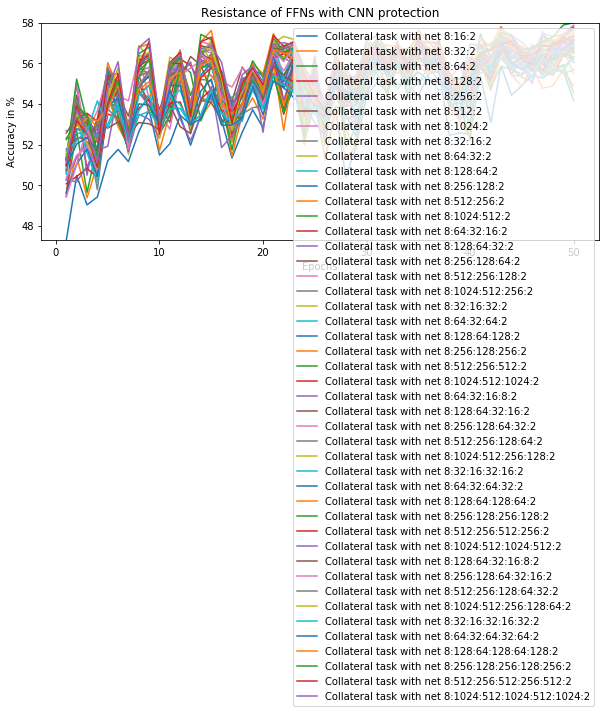

In [24]:
architectures = [
    [16], [32], [64], [128], [256], [512], [1024],
    [32, 16], [64, 32], [128, 64], [256, 128], [512, 256], [1024, 512],
    [64, 32, 16], [128, 64, 32], [256, 128, 64], [512, 256, 128], [1024, 512, 256],
    [32, 16, 32], [64, 32, 64], [128, 64, 128], [256, 128, 256], [512, 256, 512], [1024, 512, 1024],
    [64, 32, 16, 8], [128, 64, 32, 16], [256, 128, 64, 32], [512, 256, 128, 64], [1024, 512, 256, 128],
    [32, 16, 32, 16], [64, 32, 64, 32], [128, 64, 128, 64], [256, 128, 256, 128], [512, 256, 512, 256], [1024, 512, 1024, 512],
    [128, 64, 32, 16, 8], [256, 128, 64, 32, 16], [512, 256, 128, 64, 32], [1024, 512, 256, 128, 64],
    [32, 16, 32, 16, 32], [64, 32, 64, 32, 64], [128, 64, 128, 64, 128], [256, 128, 256, 128, 256], [512, 256, 512, 256, 512], [1024, 512, 1024, 512, 1024] 
]

for n_a, architecture in enumerate(architectures):
    print('\n-----', n_a,'/',len(architectures), architecture)
    for k, v in resistance_reports_nice.items():
        print((k+ ' '*100)[:40], v)
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [PRIVATE_OUTPUT_SIZE] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    resistance_reports_nice[architecture] = np.mean(test_perfs_font[-10:])
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


In [ ]:
n_params = []
accs = []
for k, v in resistance_reports_nice.items():
    n_param = 0
    sizes = [int(e) for e in k.split(':')]
    size0 = sizes[0]
    for size1 in sizes[1:]:
        n_param += (size0 + 1)* size1
        size0 = size1
    n_params.append(n_param)
    accs.append(v)

In [62]:
print(n_params)
print(accs)

[178, 354, 706, 1410, 2818, 5634, 11266, 850, 2722, 9538, 35458, 136450, 535042, 3218, 11554, 43586, 169090, 665858, 1426, 4898, 17986, 68738, 268546, 1061378, 3338, 12050, 45602, 177218, 698498, 1922, 6914, 26114, 101378, 399362, 1585154, 12170, 46098, 179234, 706626, 2498, 9090, 34562, 134658, 531458, 2111490]
[54.988, 55.373000000000005, 56.07000000000001, 55.938, 56.034000000000006, 56.165, 56.419000000000004, 55.803, 56.428999999999995, 56.242999999999995, 56.30499999999999, 55.967, 55.55899999999999, 56.911, 56.32000000000001, 56.338, 56.474000000000004, 56.248000000000005, 56.735, 56.551, 56.423, 56.522000000000006, 56.34000000000001, 56.314, 56.205, 56.717000000000006, 56.608000000000004, 56.55899999999999, 56.455000000000005, 56.589, 56.9, 56.955, 56.407000000000004, 56.586, 56.409000000000006, 56.521, 57.236000000000004, 57.022000000000006, 56.75599999999999, 55.846000000000004, 56.41799999999999, 57.097, 57.178999999999995, 56.807, 56.676]


### 6.2.2 CNN models

In [46]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(PRIVATE_OUTPUT_SIZE, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
    
         

We use several CNNS also:

Training set 60000 items
Testing set  10000 items
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229])
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.336877

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5135/10000 (51.35%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.685700

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5347/10000 (53.47%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669904

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5326/10000 (53.26%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.697268

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5244/10000 (52.44%)
tensor([ 0.0109, -0.


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5681/10000 (56.81%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 36 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.694656

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5607/10000 (56.07%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 37 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.653508

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5655/10000 (56.55%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 38 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.705169

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5469/10000 (54.69%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.669618

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5589/10000 (55.89%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 20 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693312

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5503/10000 (55.03%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.711852

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5651/10000 (56.51%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 22 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.678060

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5647/10000 (56.47%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681558

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5149/10000 (51.49%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695877

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4972/10000 (49.72%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695975

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5312/10000 (53.12%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.693180

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5519/10000 (55.19%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688772

Test set: Accuracy Char : 0/10000 (0.00%)
 


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5486/10000 (54.86%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 39 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.672438

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5497/10000 (54.97%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 40 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.677317

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5452/10000 (54.52%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 41 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.703750

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5680/10000 (56.80%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.646090

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5658/10000 (56.58%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 23 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.676981

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5670/10000 (56.70%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.651772

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5442/10000 (54.42%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.659710

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5504/10000 (55.04%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695623

Test set: Accuracy Char : 0/10000 (0.00


Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5537/10000 (55.37%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.688313

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5228/10000 (52.28%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.690590

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5535/10000 (55.35%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.689185

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5612/10000 (56.12%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.681027

Test set: Accuracy Char : 0/10000 (0.00%)



Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5644/10000 (56.44%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 42 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.643046

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5593/10000 (55.93%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 43 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.706174

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5746/10000 (57.46%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 44 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.682535

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5684/10000 (56.84%)
tensor([ 0.0109, -0.0117, -0.0270,  0.0132, -0.0229], grad_fn=<SelectBackward>)
Train Epoch: 45 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.695550

Test set: Accuracy Char : 0/10000 (0.00

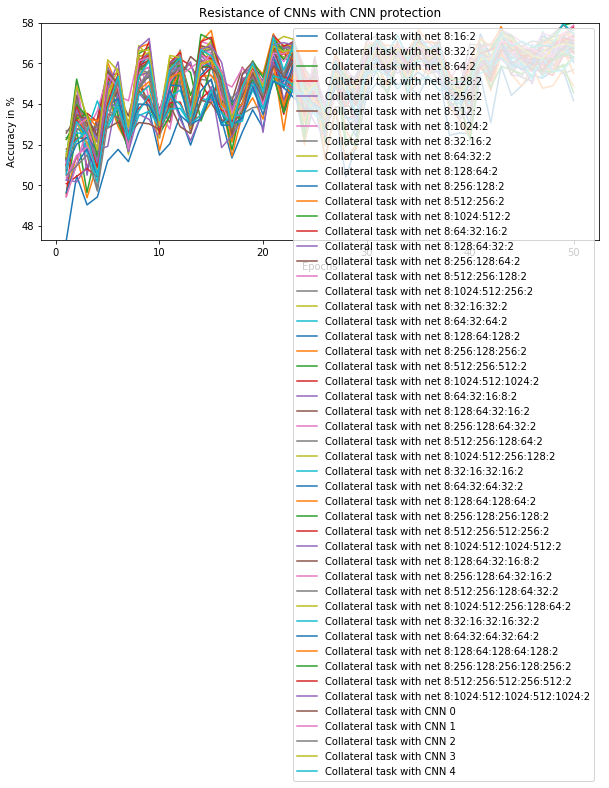

In [47]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 512),
        nn.Linear(512, N_FONTS)
    )
,
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 512),
        nn.Linear(512, 256),
        nn.Linear(256, N_FONTS)
    )
,
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 512),
        nn.Linear(512, 256),
        nn.Linear(256, 128),
        nn.Linear(128, 64),
        nn.Linear(64, N_FONTS)
    )
,
    (
        nn.Conv2d(1, 40, 5, 1),
        nn.Conv2d(40, 100, 5, 1),
        nn.Linear(100 * 4 * 4, 1024),
        nn.Linear(1024, 128),
        nn.Linear(128, N_FONTS)
    )
,
    (
        nn.Conv2d(1, 40, 5, 1),
        nn.Conv2d(40, 100, 5, 1),
        nn.Linear(100 * 4 * 4, 1024),
        nn.Linear(1024, 512),
        nn.Linear(512, 256),
        nn.Linear(256, 128),
        nn.Linear(128, N_FONTS)
    )
]
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

A rough estimation of the number of parameters:

In [188]:
[
    144*20 + 16*50 + 4*4*50* 512 + 1024,
    144*20 + 16*50 + 4*4*50* 512 + 512 * 256 + 256 * 2,
    144*20 + 16*50 + 4*4*50* 512 + 512 * 256 + 256 * 128 + 128 * 64 + 62 * 2,
    144*40 + 16*100 + 4*4*100* 1024 +  1024 * 128 + 128*2,
    144*40 + 16*100 + 4*4*100* 1024 + 1024 * 512 + 512 * 256 + 256 * 128 + 128 * 2
]
# [414304, 544864, 585436, 1777088, 2334144]

[414304, 544864, 585436, 1777088, 2334144]

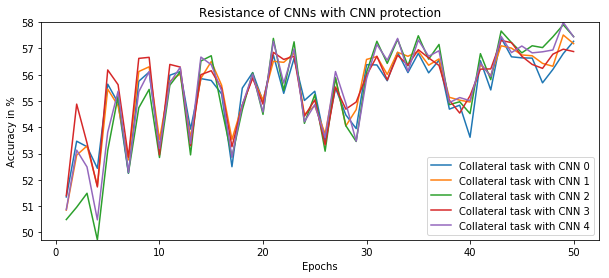

In [48]:
show_results(
    {k:v for k, v in resistance_reports.items() if 'CNN' in k}, 
    title="Resistance of CNNs with CNN protection"
)

In [63]:
cnn_results = {k:v for k, v in resistance_reports.items() if 'CNN' in k}

In [69]:
cnn_cplx = [414304, 544864, 585436, 1777088, 2334144]
cnn_accs = []
for k, v in cnn_results.items():
    cnn_accs.append(np.mean(v[-10:]))
    print(k, np.mean(v[-10:]))
    
print(cnn_accs)

Collateral task with CNN 0 56.52600000000001
Collateral task with CNN 1 56.738
Collateral task with CNN 2 57.124
Collateral task with CNN 3 56.690999999999995
Collateral task with CNN 4 56.98299999999999
[56.52600000000001, 56.738, 57.124, 56.690999999999995, 56.98299999999999]


I should have a fancy figure to show you how it is, but I think I lost it :/

Oh here it is (but its a bit dirty nvm)

In [189]:
n_params = [178, 354, 706, 1410, 2818, 5634, 11266, 850, 2722, 9538, 35458, 136450, 535042, 3218, 11554, 43586, 169090, 665858, 1426, 4898, 17986, 68738, 268546, 1061378, 3338, 12050, 45602, 177218, 698498, 1922, 6914, 26114, 101378, 399362, 1585154, 12170, 46098, 179234, 706626, 2498, 9090, 34562, 134658, 531458, 2111490]
accs = [54.988, 55.373000000000005, 56.07000000000001, 55.938, 56.034000000000006, 56.165, 56.419000000000004, 55.803, 56.428999999999995, 56.242999999999995, 56.30499999999999, 55.967, 55.55899999999999, 56.911, 56.32000000000001, 56.338, 56.474000000000004, 56.248000000000005, 56.735, 56.551, 56.423, 56.522000000000006, 56.34000000000001, 56.314, 56.205, 56.717000000000006, 56.608000000000004, 56.55899999999999, 56.455000000000005, 56.589, 56.9, 56.955, 56.407000000000004, 56.586, 56.409000000000006, 56.521, 57.236000000000004, 57.022000000000006, 56.75599999999999, 55.846000000000004, 56.41799999999999, 57.097, 57.178999999999995, 56.807, 56.676]

In [190]:
cnn_params = [414304, 544864, 585436, 1777088, 2334144]
cnn_accs = [56.52600000000001, 56.738, 57.124, 56.690999999999995, 56.98299999999999]
log_cnn_params = [np.log(e) for e in cnn_params]

In [191]:
import matplotlib.pyplot as plt
import numpy as np

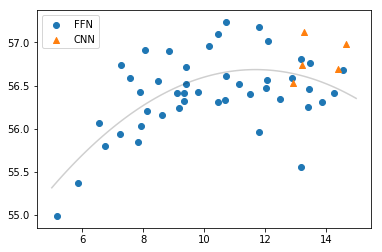

In [192]:
log_params = [np.log(e) for e in n_params]
z = np.polyfit(log_params + log_cnn_params, accs + cnn_accs, 2)
p = np.poly1d(z)

xp = np.linspace(5, 15, 100)
plt.plot(xp, p(xp), '-', c="#11111133")
plt.scatter(log_params, accs, label="FFN")
plt.scatter(log_cnn_params, cnn_accs, label="CNN", marker="^")
plt.legend()
#plt.xlim(0, 100000)
#plt.show()
plt.savefig('NNadvAcc.png', dpi=300)

## 6.3 Non-NN models

We now test many models from the sklearn library, but this time with cross validation

### Data preparation

In [91]:
transform = BaseNet(quadratic_model)

In [92]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': N_CHARS, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [103]:
train_inputs, train_labels, train_label_one_hots = [], [], []
test_inputs, test_labels, test_label_one_hots = [], [], []
for cv in range(7):
    train_dataset, test_dataset = collateral.data.get_collateral_datasets(fonts[0], fonts[1], letter, cv=cv)
    
    train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
    train_inputs.append(train_input)
    train_labels.append(train_label)
    train_label_one_hots.append(train_label_one_hot)
    
    test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")
    test_inputs.append(test_input)
    test_labels.append(test_label)
    test_label_one_hots.append(test_label_one_hot)

Training set 60000 items
Testing set  10000 items
Training set 60000 items
Testing set  10000 items
Training set 60000 items
Testing set  10000 items
Training set 60000 items
Testing set  10000 items
Training set 60000 items
Testing set  10000 items
Training set 60000 items
Testing set  10000 items
Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [104]:
train_inputs = [transform.quad(train_input).detach().numpy() for train_input in train_inputs]
test_inputs = [transform.quad(test_input).detach().numpy() for test_input in test_inputs]

In [105]:
train_labels = [train_label.reshape(-1) for train_label in train_labels]
test_label = [test_label.reshape(-1) for test_label in test_labels]

In [106]:
train_inputs[0].shape, train_labels[0].shape

((60000, 4), torch.Size([60000]))

In [107]:
ALL = train_inputs[0].shape[0]
CPOWER = 'LOW'

In [108]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [119]:
def evaluate_sklearn(reg, cv, one_hot=True, limit=int(10e10)):
    if cv=='all':
        accs = []
        for cv_ in range(7):
            accs.append(evaluate_sklearn(reg, cv_, one_hot, limit))    
        return accs
    
    train_labels_or_hots = {True: train_label_one_hots, False: train_labels}[one_hot]
    reg.fit(train_inputs[cv][:limit], train_labels_or_hots[cv][:limit].detach().numpy()) 
    output = reg.predict(test_inputs[cv])
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_labels[cv].view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### Linear models

In [120]:
reg = linear_model.Ridge(alpha=.9)
accs = evaluate_sklearn(reg, cv='all')
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['linear model Ridge'] = np.mean(accs) * 100

[0.5242, 0.5264, 0.5216, 0.5327, 0.5268, 0.5132, 0.5294]
0.5248999999999999
0.0057967971452222745


In [121]:
reg = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], cv=5)
accs = evaluate_sklearn(reg, cv='all')
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5242, 0.5264, 0.5216, 0.5327, 0.5268, 0.5132, 0.5294]
0.5248999999999999
0.0057967971452222745


In [122]:
reg = linear_model.Lasso(alpha=0.1)
accs = evaluate_sklearn(reg, cv='all')
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['linear model Lasso'] = np.mean(accs) * 100

[0.5105, 0.5136, 0.5094, 0.5151, 0.5108, 0.5005, 0.5144]
0.5106142857142857
0.004585514014318385


In [83]:
reg = linear_model.LassoLars(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)

0.5032


In [124]:
reg = linear_model.BayesianRidge()
accs = evaluate_sklearn(reg, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5241, 0.5265, 0.5215, 0.5323, 0.5269, 0.5134, 0.5293]
0.5248571428571428
0.005670942764367739


In [134]:
reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', max_iter=1000)
accs = evaluate_sklearn(reg, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['logistic regression'] = np.mean(accs) * 100

[0.5243, 0.5265, 0.5216, 0.5328, 0.527, 0.5131, 0.5294]
0.5249571428571429
0.005856585339319733


In [135]:
reg = linear_model.LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
accs = evaluate_sklearn(reg, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5239, 0.5263, 0.5212, 0.5325, 0.5273, 0.5136, 0.5294]
0.5248857142857143
0.00570849706801276


### Quadratic Discriminant Analysis

In [136]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [137]:
clf = QuadraticDiscriminantAnalysis()
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['Quadratic Discriminant Analysis'] = np.mean(accs) * 100

[0.5524, 0.5462, 0.5472, 0.5507, 0.55, 0.543, 0.5532]
0.5489571428571429
0.00338393563889197


### Kernel Ridge

In [138]:
clf = kernel_ridge.KernelRidge(alpha=1.0)
limit = {'LOW': 15000, 'MEDIUM': ALL, 'HIGH': ALL}
accs = evaluate_sklearn(clf, cv='all', one_hot=False, limit=limit[CPOWER])
print(accs)
print(np.mean(accs))
print(np.std(accs))

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=4.19887e-09): result may not be accurate.
  overwrite_a=False)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=3.74086e-09): result may not be accurate.
  overwrite_a=False)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=4.17208e-09): result may not be accurate.
  overwrite_a=False)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=4.17208e-09): result may not be accurate.
  overwrite_a=False)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=4.17208e-09): result may not be accurate.
  overwrite

[0.4684, 0.469, 0.476, 0.4657, 0.4671, 0.4784, 0.4696]
0.4706
0.004386016741548395


### SVM

In [139]:
clf = svm.SVC(gamma='scale', kernel='linear')
limit = {'LOW': 5000, 'MEDIUM': 15000, 'HIGH': ALL}
accs = evaluate_sklearn(clf, cv='all', one_hot=False, limit=limit[CPOWER])
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5409, 0.5394, 0.533, 0.544, 0.5334, 0.529, 0.5434]
0.5375857142857143
0.0053650798346952


In [140]:
clf = svm.SVC(gamma='scale', kernel='rbf')
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
accs = evaluate_sklearn(clf, cv='all', one_hot=False, limit=limit[CPOWER])
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['SVM (rbf)'] = np.mean(accs) * 100

[0.5792, 0.5715, 0.5841, 0.5779, 0.5775, 0.5838, 0.5799]
0.5791285714285715
0.003955001999535073


In [141]:
clf = svm.SVC(gamma='scale', kernel='poly', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
accs = evaluate_sklearn(clf, cv='all', one_hot=False, limit=limit[CPOWER])
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5518, 0.551, 0.5511, 0.5549, 0.5443, 0.5449, 0.5548]
0.5504
0.003961961995923567


In [142]:
clf = svm.SVC(gamma='scale', kernel='sigmoid', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
accs = evaluate_sklearn(clf, cv='all', one_hot=False, limit=limit[CPOWER])
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.483, 0.4831, 0.5121, 0.5196, 0.5169, 0.5098, 0.5194]
0.5062714285714286
0.015061181350527237


### Stochastic gradient Descent

In [178]:
clf = linear_model.SGDClassifier(loss="hinge", penalty="l2")
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['SGDClassifier'] = np.mean(accs) * 100

[0.5217, 0.5135, 0.5173, 0.5072, 0.5314, 0.5148, 0.5111]
0.5167142857142858
0.00733785265814551


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. I

In [144]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss="log")
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.4968, 0.5227, 0.5015, 0.5429, 0.4966, 0.5028, 0.5147]
0.5111428571428571
0.0157413792409739


### K-Neighbors Classifier

In [146]:
from sklearn.neighbors import KNeighborsClassifier

In [147]:
clf = KNeighborsClassifier(n_neighbors=7)
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['K-Neighbors Classifier'] = np.mean(accs) * 100

[0.5861, 0.5757, 0.5884, 0.5862, 0.5728, 0.5856, 0.5715]
0.5809
0.006702664715299016


### Gaussian process (not scalable)

In [148]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [187]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
limit = {'LOW': 1700, 'MEDIUM': 5000, 'HIGH': 20000}
accs = evaluate_sklearn(gpc, cv='all', one_hot=False, limit=500)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['Gaussian process'] = np.mean(accs) * 100

[0.5407, 0.5441, 0.5356, 0.5371, 0.5388, 0.5369, 0.5361]
0.5384714285714286
0.002802404215625416


### Naive Bayes

In [150]:
from sklearn.naive_bayes import GaussianNB

In [151]:

gnb = GaussianNB()
accs = evaluate_sklearn(gnb, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5274, 0.5299, 0.535, 0.5295, 0.536, 0.5247, 0.5417]
0.5320285714285715
0.005400982525883399


### Decision Tree Classifier

In [152]:
from sklearn.tree import DecisionTreeClassifier

In [153]:

clf = DecisionTreeClassifier(max_depth=5)
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))

resistance_reports['Decision Tree Classifier'] = np.mean(accs) * 100

[0.5675, 0.5631, 0.5656, 0.5719, 0.5763, 0.5648, 0.5678]
0.5681428571428572
0.004213195985016989


### Ensemble methods

In [154]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [180]:
clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['Random Forest Classifier'] = np.mean(accs) * 100

[0.588, 0.5877, 0.5927, 0.5912, 0.5887, 0.5914, 0.5897]
0.5899142857142856
0.0017610293835697167


In [156]:
clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.)
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['AdaBoost Classifier'] = np.mean(accs) * 100

[0.5649, 0.5725, 0.5676, 0.5654, 0.5671, 0.5694, 0.5709]
0.5682571428571428
0.002604862016009482


In [179]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))
resistance_reports['Gradient Boosting Classifier'] = np.mean(accs) * 100

[0.5878, 0.5907, 0.5874, 0.588, 0.5854, 0.5908, 0.5906]
0.5886714285714286
0.0019233262004842964


### (sklearn) Neural Network

In [158]:
from sklearn.neural_network import MLPClassifier

In [159]:
clf = MLPClassifier(solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(10, 40, 10), random_state=1)
accs = evaluate_sklearn(clf, cv='all', one_hot=False)
print(accs)
print(np.mean(accs))
print(np.std(accs))

[0.5726, 0.5474, 0.5367, 0.5641, 0.5623, 0.5429, 0.5785]
0.5577857142857143
0.014554570079671949
